# Michelle Kouba
# Data Scraping, Cleaning, and Merging in SQL

#### Preparing and Merging 3 Different Types of Data (Flattened file, Wikipedia table, and API data pull)

The flattened datafile is housed in kaggle at https://www.kaggle.com/datasets/imdevskp/corona-virus-report.  This file is a COVID19 dataset that collected data internationally until January 30, 2020 (so the first year or so of COVID).  It contains confirmed cases and deaths by country as well as other data by country.  It alone contains over 8,000 records of data and 30 variables (satisfying the 1000 by 30 requirements).

The API I will be collecting data from has world population estimates by country to help transfer the cases per country into rates (much more effective data given that the populations between all the different countries are vastly different).   The SQL join will help filter out data that is present in one file and not the other.  It also contains life expectancy estimates which is a helpful indicator of the health of a population which I might be interested in correlating with recovery (vs death) of covid19 cases to see if the health of the data made it more likely to have a lower death rate from COVID.  This data is housed here: https://www.programmableweb.com/api/world-population

The website chart/table I will be using as my third file is current cases of covid (at least much more current than 2020) so I will be incorporating this data for a trending pattern to see if the cases/deaths is rising and falling in "healthier" nations.  This chart is at: https://apify.com/covid-19

#### Relationships

Each of the files has a country field so I will be joining them all together using inner joins (we don't want countries that don't have data in all three tables as we have plenty of countries to analyze).  

## Cleaning and Preparing the Flattened File

In [ ]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
import sqlite3
import squarify
import plotly.express as px
from pywaffle import Waffle

In [ ]:
# Reading the COVID file saved to the working directory.  This is the file of data from January 30, 2020.
COVID = pd.read_csv("COVID.csv")

In [ ]:
# Finding the shape of the dataframe and the total number of records = 187 records and 15 variables
COVID.shape

(187, 15)

In [ ]:
# Collecting the variables I want into a smaller file (only need country, cases, deaths, recovered and current/unknown, saving
# region to do some aggregate results for curiosity sake)
df = COVID[['Country/Region','Confirmed','Deaths','Recovered','WHO Region']]

In [ ]:
# Inspecting the file initially to look at the data and how it's pulling in and formatted.
df.head()

,Country/Region,Confirmed,Deaths,Recovered,WHO Region
0,Afghanistan,36263,1269,25198,Eastern Mediterranean
1,Albania,4880,144,2745,Europe
2,Algeria,27973,1163,18837,Africa
3,Andorra,907,52,803,Europe
4,Angola,950,41,242,Africa


In [ ]:
# Renaming the column names to something more usable for when I merge with other data.
df = df.rename(columns={'Country/Region': 'country', 'Confirmed': 'cases', 'Deaths': 'deaths', 'Recovered': 'recovered', 'WHO Region': 'region'})
df.head()

,country,cases,deaths,recovered,region
0,Afghanistan,36263,1269,25198,Eastern Mediterranean
1,Albania,4880,144,2745,Europe
2,Algeria,27973,1163,18837,Africa
3,Andorra,907,52,803,Europe
4,Angola,950,41,242,Africa


In [ ]:
# Looking for duplicates of country names as those will need to be added or thrown out.
print("Country is duplicated - {}".format(any(df.country.duplicated())))

Country is duplicated - False


In [ ]:
# Looking for missing values for any of the countries' data or country names as they will likely not be used as well.
df.isnull().sum()

country      0
cases        0
deaths       0
recovered    0
region       0
dtype: int64

In [ ]:
# Looking for outliers signifying out of bound data or incorrectly entered.   Might be to be replaced or thrown out.
df.describe()

,cases,deaths,recovered
count,1.870000e+02,187.000000,1.870000e+02
mean,8.813094e+04,3497.518717,5.063148e+04
std,3.833187e+05,14100.002482,1.901882e+05
min,1.000000e+01,0.000000,0.000000e+00
25%,1.114000e+03,18.500000,6.265000e+02
50%,5.059000e+03,108.000000,2.815000e+03
75%,4.046050e+04,734.000000,2.260600e+04
max,4.290259e+06,148011.000000,1.846641e+06


There are no duplicate entries for a country, missing values, or outliers that I feel comfortable removing as we will remove the entire data for that country.   Some countries are smaller and larger so I don't feel like any of the data appears to be outliers or incorrectly entered at this time.

In [ ]:
# Calculating unknown values for outcome (those who neither died nor recovered).   Most likely these were current cases at the time.
df['current'] = df['cases'] - df['deaths'] - df['recovered']
df.head()

,country,cases,deaths,recovered,region,current
0,Afghanistan,36263,1269,25198,Eastern Mediterranean,9796
1,Albania,4880,144,2745,Europe,1991
2,Algeria,27973,1163,18837,Africa,7973
3,Andorra,907,52,803,Europe,52
4,Angola,950,41,242,Africa,667


In [ ]:
# Replacing all country names with lower-case letters (and removing whitespace) to match up with other merged data.
# Cleaning the whitespace from each country.
# Function to clean the whitespace.
def clean_cell (cell):
    # Converts all the countries to lower case
    cell = cell.lower()
    # Removes extra the whitespace
    return cell.strip()
# Using apply to apply this function to each of the countries and placing in a temp variable.
df['country_temp'] = df['country'].apply(clean_cell)
# Copying the values from the new column back into their original columns.
df['country'] = df['country_temp']
# Dropping the new column as it's no longer needed.
df.drop(labels='country_temp', axis=1, inplace=True)
df
df.to_csv('df.csv')

## Cleaning and Formatting the Data Scraped from a Table on Wikipeda

In [ ]:
#Import libraries
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Reading in the html from the webpage
table_covid = pd.read_html("https://en.wikipedia.org/wiki/Deployment_of_COVID-19_vaccines")
# Printing the number of tables on the webpage
print(f'Total tables: {len(table_covid)}')
# There are 53 tables on the page.

Total tables: 53


In [ ]:
# Grabbing the right table labeled vaccine distribution.
table_covid = pd.read_html('https://en.wikipedia.org/wiki/Deployment_of_COVID-19_vaccines', match='vaccine distribution')
len(table_covid)
web_df = table_covid[0]
web_df.head()

,Unnamed: 0,Location,Vaccinated[a],Percent[b]
0,NaN,World[c][d],5555277490,69.66%
1,NaN,China[e],1310292000,91.89%
2,NaN,India,1027371115,72.49%
3,NaN,European Union[f],338174656,75.13%
4,NaN,United States[g],269459752,81.16%


In [ ]:
# Relabeling columns
web_df = web_df.rename(columns={'Location': 'country', 'Vaccinated[a]': 'vaccinated', 'Percent[b]': 'percent_vacc'})

In [ ]:
# Removing extra column in front
web_df = web_df[['country','vaccinated', 'percent_vacc']]
web_df.head()

,country,vaccinated,percent_vacc
0,World[c][d],5555277490,69.66%
1,China[e],1310292000,91.89%
2,India,1027371115,72.49%
3,European Union[f],338174656,75.13%
4,United States[g],269459752,81.16%


In [ ]:
# Replacing all country names with lower-case letters (and removing whitespace) to match up with other merged data.
# Cleaning the whitespace from each country.

# Function to clean the whitespace.
def clean_cell (cell):
    # Converts all the countries to lower case
    cell = cell.lower()
    # Removes extra the whitespace
    cell = cell.strip()
     # strips [a] formatting off of some of the countries
    head, sep, tail = cell.partition('[')
    return head
# Using apply to apply this function to each of the countries and placing in a temp variable.
web_df['country_temp'] = web_df['country'].apply(clean_cell)
# Copying the values from the new column back into their original columns.
web_df['country'] = web_df['country_temp']
# Dropping the new column as it's no longer needed.
web_df.drop(labels='country_temp', axis=1, inplace=True)
web_df
web_df.to_csv('web_df.csv')

In [ ]:
# Removing the last row.
web_df.drop(web_df.tail(1).index,inplace=True)
web_df
web_df.to_csv('web_df.csv')

In [ ]:
# Data is ready to merge with flattened file!

## Collecting, Cleaning, and Formatting the API Data

In [ ]:
# Importing API data for worldwide covid statistics.
# Calling api url using requests library
import requests
api_url = 'https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/ncov_cases2_v1/FeatureServer/2/query?where=1%3D1&outFields=*&returnGeometry=false&outSR=4326&f=json'
response = requests.get(api_url)
response
# 200 means the request is successful

<Response [200]>

In [ ]:
# Extracting data from the request using json()
json = response.json()
json

{'objectIdFieldName': 'OBJECTID',
 'uniqueIdField': {'name': 'OBJECTID', 'isSystemMaintained': True},
 'globalIdFieldName': '',
 'geometryType': 'esriGeometryPoint',
 'spatialReference': {'wkid': 4326, 'latestWkid': 4326},
 'fields': [{'name': 'OBJECTID',
   'type': 'esriFieldTypeOID',
   'alias': 'OBJECTID',
   'sqlType': 'sqlTypeOther',
   'domain': None,
   'defaultValue': None},
  {'name': 'Country_Region',
   'type': 'esriFieldTypeString',
   'alias': 'Country/Region',
   'sqlType': 'sqlTypeOther',
   'length': 256,
   'domain': None,
   'defaultValue': None},
  {'name': 'Last_Update',
   'type': 'esriFieldTypeDate',
   'alias': 'Last Update',
   'sqlType': 'sqlTypeOther',
   'length': 8,
   'domain': None,
   'defaultValue': None},
  {'name': 'Lat',
   'type': 'esriFieldTypeDouble',
   'alias': 'Latitude',
   'sqlType': 'sqlTypeOther',
   'domain': None,
   'defaultValue': None},
  {'name': 'Long_',
   'type': 'esriFieldTypeDouble',
   'alias': 'Longitude',
   'sqlType': 'sqlType

In [ ]:
# Pushing the data into a dataframe
from arcgis.features import FeatureLayer
src_url = "https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1"
fl = FeatureLayer(url=src_url)
api_data = fl.query(where="1=1",
                     return_geometry=True,
                     as_df=True)

In [ ]:
# Saving to a pandas dataframe and a csv.
api_df = pd.DataFrame(api_data)
api_df

In [ ]:
# Selecting the columns I want to keep.  Recovered and active are completely blank so I will not
# keep those.
api_df = api_df[['Country_Region', 'Confirmed', 'Deaths']]
api_df.head(15)

,Country_Region,Confirmed,Deaths
0,Afghanistan,195631,7787
1,Albania,330948,3584
2,Algeria,270532,6879
3,Andorra,46113,155
4,Angola,103131,1917
5,Antarctica,11,0
6,Antigua and Barbuda,8974,145
7,Argentina,9689861,129769
8,Armenia,436727,8662
9,Australia,203680,125


In [ ]:
# Noticing that the data is stored by state/region sometimes so I need to sum all the states and regions
# together to get an aggregate rate for each country in some cases.
api_df = api_df.groupby('Country_Region').agg({'Confirmed':'sum', 'Deaths': 'sum'}).reset_index()
api_df.head()

,Country_Region,Confirmed,Deaths
0,Afghanistan,195631,7787
1,Albania,330948,3584
2,Algeria,270532,6879
3,Andorra,46113,155
4,Angola,103131,1917


In [ ]:
# Relabeling column so that the country column can be used to merge all three files together
api_df = api_df.rename(columns={'Country_Region': 'country'})
api_df.head()

,country,Confirmed,Deaths
0,Afghanistan,195631,7787
1,Albania,330948,3584
2,Algeria,270532,6879
3,Andorra,46113,155
4,Angola,103131,1917


In [ ]:
# Replacing all country names with lower-case letters (and removing whitespace) to match up with other merged data.
# Cleaning the whitespace from each country.
# Function to clean the whitespace.
def clean_cell (cell):
    # Converts all the countries to lower case
    cell = cell.lower()
    # Removes extra the whitespace
    cell = cell.strip()
     # strips [a] formatting off of some of the countries
    head, sep, tail = cell.partition('[')
    return head
# Using apply to apply this function to each of the countries and placing in a temp variable.
api_df['country_temp'] = api_df['country'].apply(clean_cell)
# Copying the values from the new column back into their original columns.
api_df['country'] = api_df['country_temp']
# Dropping the new column as it's no longer needed.
api_df.drop(labels='country_temp', axis=1, inplace=True)
api_df
api_df.to_csv('api_df.csv')

In [ ]:
# I'm not worried about the extra data from olympics and cruise ships and the like as I'll do an inner join
# to get the data that is common to all three data sources.
# All three data sources are ready to merge!!

## Merging the Data and Storing in a Database

In [ ]:
# Joining the three tables together in Python into 1 dataset.  Data was first loaded into a SQL
# with the tables labeled as df, web_df, and api_df.
conn = pyodbc.connect('DRIVER={SQL Server}; DATABASE='FinalProject')
cursor = conn.cursor()
# Insert the 3 Dataframes into SQL Server:
for index, row in df.iterrows():
     cursor.execute("INSERT INTO FinalProject.df (country, cases, deaths, recovered, region, current) values(?,?,?)")
for index, row in web_df.iterrows():
    cursor.execute("INSERT INTO FinalProject.web_df (country, vaccinated, percent_vacc) values(?,?,?)")
for index, row in api_df.iterrows():
    cursor.execute("INSERT INTO FinalProject.api_df (country, confirmed) values(?,?,?)")
conn.commit()
cursor.close()

In [ ]:
# Connecting to the database FinalProject
conn = sqlite3.connect("FinalProject.db")

In [ ]:
# Create cursor object
cursor = conn.cursor()

# Query for INNER JOIN
sql = '''SELECT df.country, cases, df.deaths, recovered, region, current, web_df.vaccinated, web_df.percent_vacc, api_df.confirmed
FROM df
INNER JOIN web_df ON df.country = web_df.country
INNER JOIN api_df ON df.country = api_df.country;'''

# Executing the query
cursor.execute(sql)

# Fetching rows from the result table
result = cursor.fetchall()
for row in result:
    print(row)

# Saving data to a pandas dataframe
full_df = pd.read_sql(sql, conn)

# Closing the connection
conn.close()


('afghanistan', '36263', '1269', '25198', 'Eastern Mediterranean', '9796', '12603710', '30.64%', '195631')
('albania', '4880', '144', '2745', 'Europe', '1991', '1345763', '47.35%', '330948')
('algeria', '27973', '1163', '18837', 'Africa', '7973', '7840131', '17.75%', '270532')
('andorra', '907', '52', '803', 'Europe', '52', '57901', '72.52%', '46113')
('angola', '950', '41', '242', 'Africa', '667', '15198308', '42.71%', '103131')
('antigua and barbuda', '86', '3', '65', 'Americas', '18', '64290', '68.97%', '8974')
('argentina', '167416', '3059', '72575', 'Americas', '91782', '41466960', '91.12%', '9689861')
('armenia', '37390', '711', '26665', 'Europe', '10014', '1128072', '38.01%', '436727')
('australia', '15303', '167', '9311', 'Western Pacific', '5825', '22236698', '84.95%', '10114810')
('austria', '20558', '713', '18246', 'Europe', '1599', '6895915', '77.14%', '4984809')
('azerbaijan', '30446', '423', '23242', 'Europe', '6781', '5373253', '52.10%', '817596')
('bahamas', '382', '11'

In [ ]:
# Inspecting and displaying merged dataframe
full_df.head()
# Saving to csv file just in case it needs to be turned in or the API has different data later, etc.....
full_df.to_csv('milestone5.csv')
full_df.head()

,country,cases,deaths,recovered,region,current,vaccinated,percent_vacc,confirmed,population,death_rates
0,afghanistan,36263.0,1269.0,25198.0,Eastern Mediterranean,9796.0,12603710.0,30.64,195631.0,411348.237598,308.497736
1,albania,4880.0,144.0,2745.0,Europe,1991.0,1345763.0,47.35,330948.0,28421.605069,506.656818
2,algeria,27973.0,1163.0,18837.0,Africa,7973.0,7840131.0,17.75,270532.0,441697.521127,263.302361
3,andorra,907.0,52.0,803.0,Europe,52.0,57901.0,72.52,46113.0,798.414231,6512.909967
4,angola,950.0,41.0,242.0,Africa,667.0,15198308.0,42.71,103131.0,355848.934676,11.521743


In [ ]:
full_df = pd.read_csv("milestone5.csv")

In [ ]:
# Checking the types of all the columns
full_df.dtypes

Unnamed: 0        int64
country          object
cases           float64
deaths          float64
recovered       float64
region           object
current         float64
vaccinated      float64
percent_vacc    float64
confirmed       float64
population      float64
death_rates     float64
dtype: object

In [ ]:
# Changing some of the variables to float
# Changing each cell in cases, deaths, recovered, current, vaccinated and confirmed to float
full_df['cases'] = full_df['cases'].astype(float)
full_df['deaths'] = full_df['deaths'].astype(float)
full_df['recovered'] = full_df['recovered'].astype(float)
full_df['current'] = full_df['current'].astype(float)
full_df['vaccinated'] = full_df['vaccinated'].astype(float)
full_df['confirmed'] = full_df['confirmed'].astype(float)
def strip_percent(cell):
    cell = float(cell.strip("%"))
    return cell
full_df['percent_vacc'] = full_df['percent_vacc'].astype(float)

In [ ]:
# Creating population estimates from vaccination data
full_df['population'] = full_df['vaccinated'] / full_df['percent_vacc']
# Creating COVID raw death rates per 100,000 (wish they were AADR which is more comparable but that data wasn't readily available for
# most countries)
full_df['death_rates'] = full_df['deaths'] / full_df['population'] * 100000

In [ ]:
# Since this datafile is so large, I'll be creating a second file by region for some of the data visualizations
region_df = full_df.groupby('region').agg({'deaths':'sum', 'recovered': 'sum', 'vaccinated': 'sum', 'population': 'sum'}).reset_index()
region_df

,region,deaths,recovered,vaccinated,population
0,Africa,11864.0,423556.0,3.682167e+08,1.050730e+07
1,Americas,194721.0,3142812.0,5.639130e+08,6.935113e+06
2,Eastern Mediterranean,38261.0,1197648.0,4.208789e+08,7.750309e+06
3,Europe,209007.0,1958906.0,6.237045e+08,9.171141e+06
4,South-East Asia,41343.0,1156641.0,1.486042e+09,1.990586e+07
5,Western Pacific,7942.0,193323.0,1.668665e+09,1.873609e+07


In [ ]:
# Creating COVID raw death rates per 100,000 (assuming roughly three years of data)
region_df['death_rates'] = region_df['deaths'] / region_df['population'] * 100000/3
region_df.head()
# Creating percentage vaccinated based on population (rather than averaging individual countries which would be wrong)
region_df['percent_vacc'] = region_df['vaccinated'] / region_df['population'] * 100
region_df

,region,deaths,recovered,vaccinated,population,death_rates,percent_vacc,recovered_proportion
0,Africa,11864.0,423556.0,3.682167e+08,1.050730e+07,37.637342,3504.390927,42.3556
1,Americas,194721.0,3142812.0,5.639130e+08,6.935113e+06,935.918463,8131.273202,314.2812
2,Eastern Mediterranean,38261.0,1197648.0,4.208789e+08,7.750309e+06,164.556887,5430.479232,119.7648
3,Europe,209007.0,1958906.0,6.237045e+08,9.171141e+06,759.654660,6800.729514,195.8906
4,South-East Asia,41343.0,1156641.0,1.486042e+09,1.990586e+07,69.230865,7465.348108,115.6641
5,Western Pacific,7942.0,193323.0,1.668665e+09,1.873609e+07,14.129597,8906.156965,19.3323


## Data Visualizations


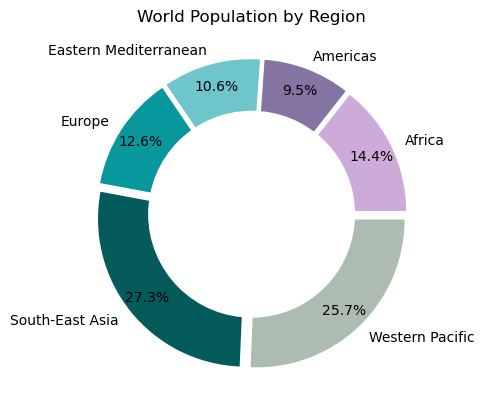

In [ ]:
# Population of the world by region
# Setting labels for items in Chart
Region = ['Africa', 'Americas', 'Eastern Mediterranean', 'Europe', 'South-East Asia', 'Western Pacific']

# Setting size in Chart based on
# given values
Population = [region_df.population]

# colors
colors = ['#CCABD8', '#8474A1', '#6EC6CA',
          '#08979D', '#055B5C', '#ACBCB1']
# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05
          )

# Pie Chart
plt.pie(region_df.population, colors=colors, labels=Region,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('World Population by Region')

# Displaying Chart
plt.show()

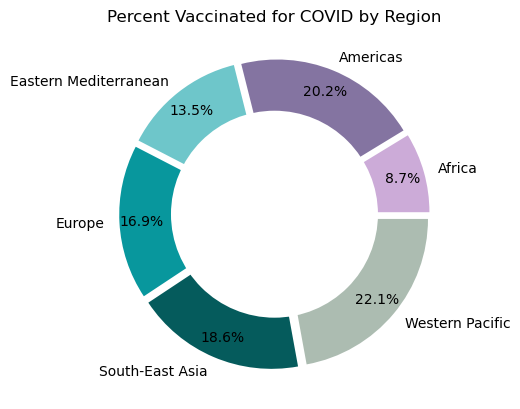

In [ ]:
# Percent Vaccinated by region
# Setting labels for items in Chart
Region = ['Africa', 'Americas', 'Eastern Mediterranean', 'Europe', 'South-East Asia', 'Western Pacific']

# Setting size in Chart based on
# given values
Percent = [region_df.percent_vacc]

# colors
colors = ['#CCABD8', '#8474A1', '#6EC6CA',
          '#08979D', '#055B5C', '#ACBCB1']
# explosion
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05
          )

# Pie Chart
plt.pie(region_df.percent_vacc, colors=colors, labels=Region,
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()

# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# Adding Title of chart
plt.title('Percent Vaccinated for COVID by Region')

# Displaying Chart
plt.show()

One would expect if vaccination percentages were the same globally that the percentage of the world's population each region holds, would be the same as those percentages vaccinated as well (meaning both of these donut maps would be similar).   However, persons from the America's are twice as likely to be vaccinated and persons from Africa are half as likely as the rest of the world's populations.  More than half of the world's populations live in South-East Asia and nearby Western Pacific, but their vaccination rates are lower when compared to the rest of the world (only 40.7% of the world's vaccinated persons live here).

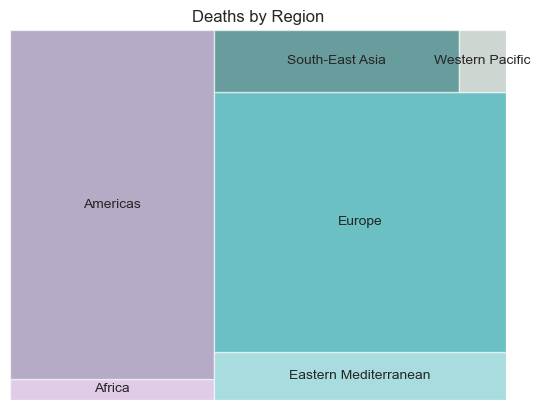

In [ ]:
# Creating a treemap for deaths across the world by region
colors=['#CCABD8', '#8474A1', '#6EC6CA',
          '#08979D', '#055B5C', '#ACBCB1'] #color palette
sns.set_style(style="whitegrid") # set seaborn plot style
sizes= region_df["deaths"].values# proportions of the categories
label = Region
squarify.plot(sizes=sizes, label=label, alpha=0.6,color=colors).set(title='Deaths by Region')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Percent Vaccinated for COVID by Raw Death Rates')

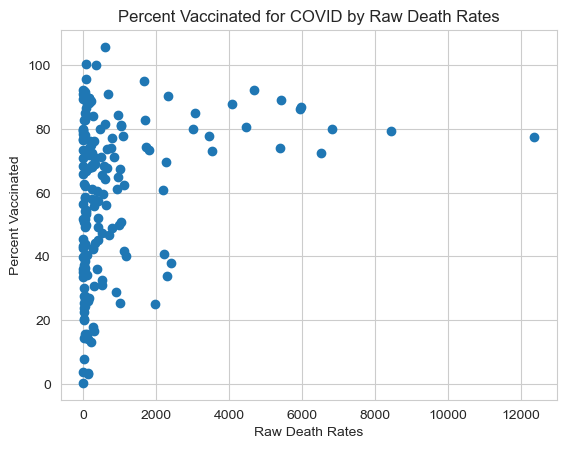

In [ ]:
# Scatterplot of Deaths Rates By Vaccination Percentages (By Country Using the
# Full File)
plt.scatter(full_df.death_rates, full_df.percent_vacc)
plt.xlabel('Raw Death Rates')
plt.ylabel('Percent Vaccinated')
plt.title('Percent Vaccinated for COVID by Raw Death Rates')

There appears to be little to no linear correlation (possibly an exponential one but that doesn't make sense).  Could be incomplete or missing data was labeled as zero deaths.

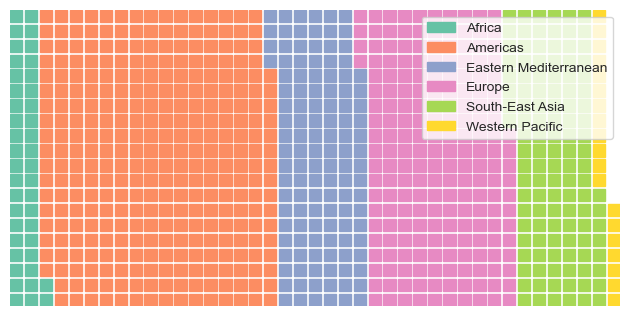

In [ ]:
# This table has bombed out twice so since it's a chart for prevalence, I'm going to divide all the deaths by 10000 so that
# they are proportional but hopefully it won't take two hours to load or load then throw a memory error.
region_df['recovered_proportion'] = region_df['recovered'] / 10000
# Waffle Chart
fig = plt.figure(
    FigureClass = Waffle,
    rows = 20,
    values = region_df.recovered_proportion,
    labels = Region
)

The largest proportion of deaths due to COVID happened in the Americas, ironically enough, where vaccination rate are the highest.  The smallest proportion of COVID deaths were in the Western Pacific where vaccination rates are also high.

Given that I suspect "what I learned from this project" is also, in part, about what I gleaned from merging these three file together, I'll speak to that as well.  While the Americas are roughly 10% of the world population, they account for double the rest of the world's vaccination rates.  Also that most of the COVID deaths occurred in the Americas and Europe.  Thus it's not surprising that both areas had the highest death rates as well.  What I didn't expect (and maybe this is due to faulty data or a zero being reported when no data was avaiable) but that COVID death rates appear to have no correlation (or perhaps even a slightly negative one) with vaccination percentages by region.

In [ ]:
# Human readable dataset (of all three datasets merged) displayed here.
full_df
full_df.to_csv('full_df.csv')